In [ ]:
!apt install graphviz
!pip install pydot pydot-ng
!python -c "import pydot"

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.utils import plot_model
from IPython.display import Image

%matplotlib inline
pd.set_option('display.max_colwidth',300)
plt.rcParams["figure.figsize"][0]=12

from sklearn.metrics import accuracy_score,f1_score

# # FOR BERT EMBEDDINGS
!pip install bert-for-tf2
!pip install sentencepiece
import bert
from bert import BertModelLayer
from bert.loader import StockBertConfig, map_stock_config_to_params, load_stock_weights
from bert.tokenization.bert_tokenization import FullTokenizer
import os

In [ ]:
import pickle
train_data = pickle.load(open('/content/drive/My Drive/tempData/train_clean_lmote.data','rb')) 
valid_data = pickle.load(open('/content/drive/My Drive/tempData/valid_clean.data','rb'))
test_data = pickle.load(open('/content/drive/My Drive/tempData/test_clean.data','rb')) 

# Sequences are sent as int32 in Input layer!
# of np array and of float 32 type!
y_train=np.asarray(train_data['label']).astype(np.float32)
y_valid=np.asarray(valid_data['label']).astype(np.float32)
y_test=np.asarray(test_data['label']).astype(np.float32)

print(train_data.shape,test_data.shape,valid_data.shape)
print(train_data['label'].value_counts(normalize = True))

(12830, 4) (592, 4) (833, 4)
1    0.5
0    0.5
Name: label, dtype: float64


In [ ]:
# # USING BERT AS A SERVICE
# !pip install tensorflow==1.13.1

# # Needs to use GPU to run
# # if not set pooling strategy to noe then we get either reduced mean, dot prod.. res as BATCHSZ*786 
# !wget https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip 
# !unzip uncased_L-12_H-768_A-12.zip
# !pip install bert-serving-server  # server
# !pip install bert-serving-client  # client, independent of `bert-serving-server`
# !nohup bert-serving-start -model_dir=/content/uncased_L-12_H-768_A-12/ -num_worker=4 -max_seq_len=50 -pooling_strategy=NONE > out.file &

# !bert-serving-terminate -port 5555
# !tail -f out.file
# from bert_serving.client import BertClient
# bc = BertClient()
# # token level embeddings if pooling strategy is none
# em = bc.encode(['First do it', 'then do it right', 'then do it better'])
# print(type(em),em)
# em.shape

# # remove empty ones
# sugg  = ''
# nonsugg = ''

# for i in range(len(train_data['cleaned'])):
#   if len(train_data['cleaned'][i])!=0:
#     if y_train[i]==1:
#       sugg = train_data['cleaned'][i]
#       break

# for i in range(len(train_data['cleaned'])):
#   if len(train_data['cleaned'][i])!=0:
#     if y_train[i]==0:
#       nonsugg = train_data['cleaned'][i]
#       break

# print(sugg)
# print(nonsugg)

# for i in range(len(train_data['cleaned'])):
#   if len(train_data['cleaned'][i])==0:
#     if y_train[i]==0:
#       train_data['cleaned'][i]=nonsugg
#     else: 
#       train_data['cleaned'][i]=sugg

# x_test = bc.encode([x for x in test_data['cleaned']]) # ~ 4sec
# x_valid = bc.encode([x for x in valid_data['cleaned']]) # ~6.5sec
# x_train = bc.encode([x for x in train_data['cleaned']]) # ~1.45mins

In [ ]:
# Using BERT as a Layer
# if not set pooling strategy to noe then we get either reduced mean, dot prod.. res as BATCHSZ*786 

!wget https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip # BERT BASE MODEL
!unzip uncased_L-12_H-768_A-12.zip

model_dir = "uncased_L-12_H-768_A-12"
bert_model_file = os.path.join(model_dir, "bert_model.ckpt")
bert_config_file = os.path.join(model_dir, "bert_config.json")
tokenizer = FullTokenizer(vocab_file=os.path.join(model_dir, "vocab.txt"))

In [ ]:
def generateSequence(sentences,max_seq_len):
  token_id_sequences=[]
  for sentence in sentences:
      tokens = tokenizer.tokenize(sentence)
      tokens = ["[CLS]"] + tokens + ["[SEP]"] # TO HELP BERT CONSIDER IT AS A SINGLE SENTENCE
      token_indexes = tokenizer.convert_tokens_to_ids(tokens)
      max_seq_len = max(max_seq_len, len(token_indexes))
      token_id_sequences.append(token_indexes)
  return np.array(token_id_sequences),max_seq_len;
  
max_seq_len=0
train_sequences,max_seq_len = generateSequence(train_data['cleaned'],max_seq_len)
test_sequences,max_seq_len = generateSequence(test_data['cleaned'],max_seq_len)
valid_sequences,max_seq_len = generateSequence(valid_data['cleaned'],max_seq_len)

# PAD SEQUENCES
max_seq_len =  60
# increasing mxlen does not gurantees higher acc!

def pad(token_id_sequences):
  final_sequences = []
  for input_ids in token_id_sequences:
    input_ids = input_ids[:min(len(input_ids), max_seq_len - 2)]
    input_ids = input_ids + [0] * (max_seq_len - len(input_ids))
    final_sequences.append(np.array(input_ids))
  return np.array(final_sequences)

x_train_sequences = pad(train_sequences)
x_valid_sequences = pad(valid_sequences)
x_test_sequences =  pad(test_sequences) 

print(x_train_sequences.shape,x_test_sequences.shape,x_valid_sequences.shape)

(12830, 60) (592, 60) (833, 60)


In [ ]:
##################################################################################################
####### ENSEMBLE CLASSIFIER  => CNN + ATTENTION MODEL + BILSTM BASED TEXT RCNN #########
##################################################################################################

from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.layers import Dense, Conv1D, GlobalMaxPooling1D,concatenate
from tensorflow.keras.layers import LSTM,Flatten,RepeatVector,Permute,Activation,Multiply,Lambda
from tensorflow.keras.layers import GlobalAveragePooling1D, GlobalMaxPool1D,Bidirectional,TimeDistributed
from tensorflow.keras.backend import sum as Ksum
from tensorflow.keras.models import Model

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy

import tensorflow

UNITS = 256
UNITS_HF = 128

with tensorflow.io.gfile.GFile(bert_config_file, "r") as reader:                # LOAD BERT CONFIGURATION...............
    bc = StockBertConfig.from_json_string(reader.read())
    bert_params = map_stock_config_to_params(bc)
    bert_params.adapter_size = None
    bert = BertModelLayer.from_params(bert_params, name="bert")

input_layer= Input(shape=(max_seq_len,), dtype='int32')                         # THE INPUT LAYER 
bert_layer =    bert(input_layer)                                               # THE BERT EMBEDDINGS 

# PART 1 - CNN CLASSIFIER 
conv1 = Conv1D(UNITS_HF, 3, activation='relu',name="Conv1D_1")(bert_layer)      
conv1 = GlobalMaxPooling1D(name="GMaxPOOL1")(conv1)
conv2 = Conv1D(UNITS_HF, 4, activation='relu',name="Conv1D_2")(bert_layer)        
conv2 = GlobalMaxPooling1D(name="GMaxPOOL2")(conv2)
cnn = concatenate([conv1,conv2],name="CNNConcat") 

# PART 2 - LSTM ATTENTION CLASSIFIER
lstm_layer = LSTM(UNITS,name="LSTM1")(bert_layer)                               
attention = Dense(1, activation='tanh',name="Dense1")(lstm_layer)
attention = Flatten(name="Flatten1")(attention)
attention = Activation('softmax')(attention)
attention = RepeatVector(UNITS,name="RepeatVec1")(attention)
attention = Permute([2, 1],name="Permute1")(attention)
sent_representation = Multiply(name="AttentionFin")([lstm_layer, attention])
rnn_attention = Lambda(lambda xin: Ksum(xin, axis=-2), output_shape=(UNITS,),name="RNNAttention")(sent_representation)

# PART 3 - BILSTM BASED TEXT RCNN CLASSIFIER
bilstm_layer = Bidirectional(LSTM(128, activation="relu",return_sequences=True,name='LSTM2'),name='BI')(bert_layer)
bilstm_layer = TimeDistributed(Dense(UNITS, activation='relu',name='Dense2'),name='TimeDis')(bilstm_layer)
conv_layer_1 = Conv1D(UNITS_HF, 3, activation='relu')(bilstm_layer)        
avg_pool_layer = GlobalAveragePooling1D(name='GAvgPool1')(conv_layer_1)
conv_layer_2 = Conv1D(UNITS_HF, 4, activation='relu',name='Conv1D3')(bilstm_layer)        
max_pool_layer = GlobalMaxPooling1D(name='GMaxPool3')(conv_layer_2)
rcnn = concatenate([avg_pool_layer,max_pool_layer]) 

# ENSEMBLE CLASSIFIER
combined_layer = concatenate([cnn,rnn_attention,rcnn],name='EnsembleConcat')
dense_layer = Dense(UNITS,name = 'DenseCombined')(combined_layer)
dense_final = Dense(UNITS_HF,activation="tanh",name = 'DenseFinal')(dense_layer)
# dropout_layer =  Dropout(0.4)(dense_layer)
output_layer = Dense(2, activation='softmax',name='OutputLayer')(dense_final)

# the model works well with the softmax layer output and so multilabel
# it does not trains of simple 1 dense output class

# SUMMARY 
ensemble_model = Model(input_layer,output_layer)
load_stock_weights(bert, bert_model_file)                                       # LOADING BERT WEIGHTS TO THE MODEL

ensemble_model.compile(
  optimizer=Adam(1e-5),
  loss=SparseCategoricalCrossentropy(from_logits=True),                         # Can be greater than 1
  metrics=[SparseCategoricalAccuracy(name="acc")]
)

# DISPLAY
plot_model(ensemble_model, show_shapes=True, show_layer_names=True, to_file='ensemble_model.png')
Image(retina=True, filename='ensemble_model.png')

In [ ]:
# TRAINING................
EPOCHS = 7
BATCH_SIZE = 100
history = ensemble_model.fit(
    x_train_sequences,y_train,
    epochs=EPOCHS,     
    validation_data=(x_valid_sequences, y_valid), 
    batch_size=BATCH_SIZE,
    shuffle=True
)

Done loading 196 BERT weights from: uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7fed81f56240> (prefix:bert_6). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Epoch 1/7
129/129 [==============================] - 141s 1s/step - loss: 0.6102 - acc: 0.6760 - val_loss: 0.5674 - val_acc: 0.7263
Epoch 2/7
129/129 [==============================] - 138s 1s/step - loss: 0.5109 - acc: 0.7956 - val_loss: 0.5508 - val_acc: 0.7467
Epoch 3/7
129/129 [==============================] - 138s 1s/step - loss: 0.4667 - acc: 0.8417 - val_

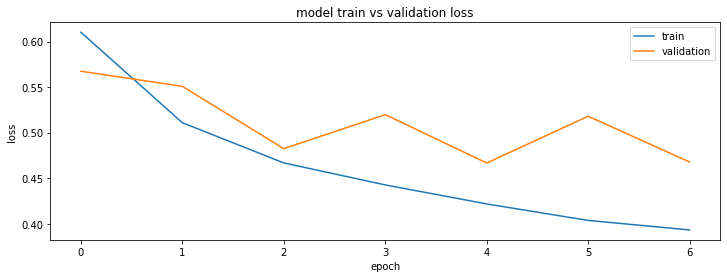

F1 Score: 78.77%
Accuracy: 77.87%


In [ ]:
# TRAINING VS VALIDATION LOSS GRAPH
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

predict=ensemble_model.predict(x_test_sequences).argmax(axis=-1)
predict=[int(x+0.5) for x in predict]
accuracy = accuracy_score(y_test, predict)
f1=f1_score(y_test,predict)
print("F1 Score: %.2f%%" % (f1* 100.0))
print("Accuracy: %.2f%%" % (accuracy * 100.0))